# The Tampa Bay Times and school performance

**Story:** [The story](http://www.tampabay.com/projects/2015/investigations/pinellas-failure-factories/), and [a critique](https://rogueedu.blogspot.com/2015/08/fcat-reading-scores-only-two-of-five.html)

**Author:** Various parts are various people! Nathaniel Lash did the good investigation, but we're reproducing a less-than-stellar approach here.

**Topics:** Linear Regression, Residuals

**Datasets**

* **0066897-gr04_rsch_2014.xls:** 4th grader pass rates for standardized tests, from Florida Dept of Education
* **FRL-1314-School-Web-Survey-3-Final.xls:** Free and reduced price lunch data, from Florida Dept of Education
* **MembershipSchoolRaceGender1415.xls:** School population by gender, from Florida Dept of Education

## What's the story?

We're trying to see what kind of effect things like race and poverty might have on school test score data by reproducing (more or less) [a critique](https://rogueedu.blogspot.com/2015/08/fcat-reading-scores-only-two-of-five.html) of the Tampa Bay Times analysis. We're doing this analysis _first_ because it's a rather typical analysis, and it will highlight what's special about the Tampa Bay Times' approach in the next section.

It's important to note that **this analysis is a naive approach that yields inaccurate results.** While the _math_ is correct and the analysis is a standard approach to issues of economics and school performance, the data contains a fatal flaw. You can skip to the bottom if you'd like to see what's so wrong.

<p class="reading-options">
  <a class="btn" href="/tampa-bay-times-schools/linear-regression-on-florida-schools">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/tampa-bay-times-schools/notebooks/Linear regression on Florida schools.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/tampa-bay-times-schools/notebooks/Linear regression on Florida schools.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **0066897-gr04_rsch_2014.xls:** test scores - fourth grade test scores as of 2014
* **FRL-1314-School-Web-Survey-3-Final.xls:** free and reduced lunch status - for the 2014 school year
* **MembershipSchoolRaceGender1415.xls:** race and gender by school - for the 2014-2015 school year


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/tampa-bay-times-schools/data/0066897-gr04_rsch_2014.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/tampa-bay-times-schools/data/FRL-1314-School-Web-Survey-3-Final.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/tampa-bay-times-schools/data/MembershipSchoolRaceGender1415.xls -P data

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

## Test scores data

While we have a lot of options for what tests we can use, let's stick with reading scores.

As is typical with government data, there's a lot of junk up at the file. Let's start by reading in the file "normally" so we can check this garbage out!

In [4]:
junk = pd.read_excel("data/0066897-gr04_rsch_2014.xls", nrows=12)
junk

,"On January 21, 2014, the State Board of Education established passing scores for all FCAT 2.0 assessments, as required by Section 1008.22(3), Florida Statutes. Although state law does not require grade 4 students to pass FCAT 2.0 Reading in order to move to the next grade level, the State Board has established the minimum score in Achievement Level 3 as the passing score for FCAT 2.0 Reading assessments.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,Note: To provide meaningful results and to pro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014 FLORIDA COMPREHENSIVE ASSESSMENT TEST® 2....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NEXT GENERATION SUNSHINE STATE STANDARDS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,State Report of School Results,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Grade 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,READING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,Total Test Scores,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mean Points Earned,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,% in each Achievement Level,NaN,NaN,NaN,NaN,NaN,By Content Area,NaN,NaN,NaN
9,Grade,District Number,District Name,School Number,School Name,Number of Students,Mean Developmental Scale Score,1,2.0,3.0,4.0,5.0,Percentage Passing (Achievement Levels 3 and A...,Vocabulary,Reading Application,Literary Analysis: Fiction and Nonfiction,Informational Text and Research Process


The real headers don't begin until down on the "Grade," "District Number," etc row, so we're going to skip the first 10 rows. We'll also need to drop the one _after_ the header, as it's more notes.

Sometimes the school number starts with `0` - for example, Charles W. Duval Elementary is School Number `0021`. Pandas (and Excel!) will assume it's a number and drop the leading zeroes, leading to a School Number of `21` instead. We'll tell `.read_csv` to read the column in as a string instead.

Finally, we're ignoring any cell with `*` in it, which is used for data that is missing or has been stripped out.

In [5]:
reading_scores = pd.read_excel("data/0066897-gr04_rsch_2014.xls",
                               skiprows=10,
                               dtype={'School Number': 'str'},
                               na_values=['*'])
reading_scores.head(4)

,Grade,District Number,District Name,School Number,School Name,Number of Students,Mean Developmental Scale Score,1,2,3,4,5,Percentage Passing (Achievement Levels 3 and Above),Vocabulary,Reading Application,Literary Analysis: Fiction and Nonfiction,Informational Text and Research Process
0,4,Number of Points Possible,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,14.0,11.0,11.0
1,4,00,STATE TOTALS,0000,GRADE 04,"196,786",213.0,14.0,25.0,26.0,24.0,11.0,61.0,6.0,10.0,8.0,8.0
2,4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,45,203.0,24.0,40.0,24.0,9.0,2.0,36.0,5.0,8.0,7.0,7.0
3,4,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,84,219.0,6.0,20.0,32.0,26.0,15.0,74.0,6.0,11.0,8.0,8.0


We'll remove that `Number of Points Possible` row and the state totals row by asking for everything after row index 2.

In [6]:
reading_scores = reading_scores.loc[2:]
reading_scores.head(4)

,Grade,District Number,District Name,School Number,School Name,Number of Students,Mean Developmental Scale Score,1,2,3,4,5,Percentage Passing (Achievement Levels 3 and Above),Vocabulary,Reading Application,Literary Analysis: Fiction and Nonfiction,Informational Text and Research Process
2,4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,45,203.0,24.0,40.0,24.0,9.0,2.0,36.0,5.0,8.0,7.0,7.0
3,4,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,84,219.0,6.0,20.0,32.0,26.0,15.0,74.0,6.0,11.0,8.0,8.0
4,4,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,85,223.0,6.0,24.0,18.0,25.0,28.0,71.0,7.0,11.0,8.0,8.0
5,4,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUDENT CENTER,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Checking out our data

How does our data look? Let's use `.describe()` since it's almost all numeric.

In [8]:
reading_scores.describe()

,Grade,Mean Developmental Scale Score,1,2,3,4,5,Percentage Passing (Achievement Levels 3 and Above),Vocabulary,Reading Application,Literary Analysis: Fiction and Nonfiction,Informational Text and Research Process
count,2207.0,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000
mean,4.0,211.737855,15.424723,26.076960,25.704185,22.721982,10.092833,58.517557,6.063973,9.651275,7.439153,7.595960
std,0.0,8.531156,10.730085,9.526966,6.327183,9.884397,8.041970,17.435445,0.799570,1.209159,0.916130,0.958375
min,4.0,175.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,5.000000,4.000000,4.000000
25%,4.0,206.000000,7.000000,19.000000,22.000000,16.000000,4.000000,46.000000,6.000000,9.000000,7.000000,7.000000
50%,4.0,211.000000,14.000000,26.000000,26.000000,22.000000,8.000000,58.000000,6.000000,10.000000,7.000000,8.000000
75%,4.0,218.000000,21.000000,32.000000,30.000000,29.000000,14.000000,72.000000,7.000000,10.000000,8.000000,8.000000
max,4.0,242.000000,86.000000,80.000000,56.000000,63.000000,62.000000,100.000000,8.000000,13.000000,10.000000,10.000000


## Lunch data

When performing analysis of schools and poverty, **lunch data is oftentimes very important.**

A typical question one would ask of a school system might go something like, "how do students who live in poverty perform?" In a world with zero privacy, you'd take the test scores of these kids along with their household income and do a study to see how the two relate. Fortunately, that data is not quite available!

Instead, you typically need to start from **school-level average test scores.** That takes care of the academic part, and then you need to somehow relate in economic forces.

As much as your research might want it, **schools don't publish the income of their students' families.** You also can't reliably use the Census income data of the surrounding areas, as you don't know where exactly these students come from, or what tracts do or do not have children.

Instead, you typically use a metric that schools *do* publish: **the rate of free and reduced lunch.** According to [the USDA](https://www.ers.usda.gov/topics/food-nutrition-assistance/child-nutrition-programs/national-school-lunch-program/), in schools that participate in the National School Lunch Program:

> Free lunches are available to children in households with incomes at or below 130 percent of poverty.
>
> Reduced-price lunches are available to children in households with incomes between 130 and 185 percent of poverty.

Other students may qualify as well, but roughly speaking it's a well-known proxy among education research.

The free or reduced lunch percentage is then compared to the test scores using regression, and there you go on your results.

First we're going to do the analysis, then we're going to **talk about the limitations of this metric,** along with a fatal flaw that destroys its use in this situation.

### Reading in lunch data

Again, we have `*` for missing data, `0021`-style school identifiers that need to be read in as strings, and finally some weird column names. We'll skip the unnecessary header rows and manually label the rest of them.

In [19]:
colnames = ['district_no', 'district_name', 'school_no', 
            'school_name', 'total_members', 'num_free', 
            'num_reduced', 'provision_2', 'direct_cert']

lunch = pd.read_excel("data/FRL-1314-School-Web-Survey-3-Final.xls",
                      sheet_name='School',
                      skiprows=5,
                      dtype={'school_no': 'str', 'district_no': 'str'},
                      names=colnames,
                      na_values=['*'])
lunch.head()

,district_no,district_name,school_no,school_name,total_members,num_free,num_reduced,provision_2,direct_cert
0,1,ALACHUA,21,CHARLES W. DUVAL ELEM SCHOOL,318.0,290.0,15.0,0.0,0.0
1,1,ALACHUA,31,J. J. FINLEY ELEMENTARY SCHOOL,589.0,297.0,25.0,0.0,0.0
2,1,ALACHUA,41,STEPHEN FOSTER ELEMENTARY SCHL,458.0,257.0,21.0,0.0,0.0
3,1,ALACHUA,52,A.QUINN JONES/EXCEP.STUD.CTR.,71.0,55.0,2.0,0.0,0.0
4,1,ALACHUA,71,LAKE FOREST ELEMENTARY SCHOOL,307.0,286.0,8.0,0.0,0.0


Notice how even though we specified `dtype` as string when we read in the district and school codes, pandas still dropped the leading zeroes! We'll use `.str.pad` to add them back in.

In [20]:
lunch.school_no = lunch.school_no.str.pad(width=4, side='left', fillchar='0')
lunch.district_no = lunch.district_no.str.pad(width=2, side='left', fillchar='0')
lunch.head(3)

,district_no,district_name,school_no,school_name,total_members,num_free,num_reduced,provision_2,direct_cert
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,318.0,290.0,15.0,0.0,0.0
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,589.0,297.0,25.0,0.0,0.0
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHL,458.0,257.0,21.0,0.0,0.0


### Feature engineering

Let's add in a new column that is the percent of students who are eligible for free or reduced-price lunch.

* Free, reduced price, provision 2, and CEP direct cert are all kinds of reduced lunch.
* Total members it the total number of students at the school
* If we run a regression, percentages work a lot better as 0-100 instead of 0-1, so we multiply by 100

In [54]:
lunch['pct_free_or_reduced'] = (lunch.num_free + lunch.num_reduced + lunch.provision_2
                                + lunch.direct_cert) / lunch.total_members * 100
lunch.head()

,district_no,district_name,school_no,school_name,total_members,num_free,num_reduced,provision_2,direct_cert,pct_free_or_reduced
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,318.0,290.0,15.0,0.0,0.0,95.911950
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,589.0,297.0,25.0,0.0,0.0,54.668930
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHL,458.0,257.0,21.0,0.0,0.0,60.698690
3,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUD.CTR.,71.0,55.0,2.0,0.0,0.0,80.281690
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,307.0,286.0,8.0,0.0,0.0,95.765472


## Race data

Again, the xls file is a little dirty so we need to set a whole bushel of options when reading it in.

In [62]:
race = pd.read_excel("data/MembershipSchoolRaceGender1415.xls",
                     sheet_name='SCHOOL',
                     skiprows=4,
                     dtype={'School #': 'str', 'District #': 'str'},
                     na_values=[' ', '*'])
race.head()

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,KG,NaN,36.0,2.0,NaN,NaN,NaN,NaN,15.0,23.0,38.0
2,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,1,NaN,33.0,3.0,1.0,NaN,NaN,NaN,16.0,21.0,37.0
3,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,2,1.0,38.0,1.0,NaN,NaN,NaN,3.0,21.0,22.0,43.0
4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,3,NaN,32.0,4.0,NaN,NaN,NaN,2.0,18.0,20.0,38.0


Each row seems to be a different **Grade**, from pre-Kindergarten to 12th grade. But if you poke down far enough, there's one weird one: `TOTAL`!

In [63]:
race[13:17]

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
13,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,01,ALACHUA,0021,SCHOOL TOTALS,TOTAL,3.0,196.0,10.0,1.0,NaN,NaN,7.0,102.0,115.0,217.0
15,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,KG,37.0,24.0,17.0,16.0,NaN,NaN,5.0,49.0,50.0,99.0


The total rows adds adds up all the other rows for that school and provides an aggregate. Instead of doing the math ourselves to compute the racial statistics for each school, we'll use these `TOTAL` rows.

In [66]:
race = race[race.Grade == 'TOTAL']
race.head()

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
14,01,ALACHUA,0021,SCHOOL TOTALS,TOTAL,3.0,196.0,10.0,1.0,0.0,0.0,7.0,102.0,115.0,217.0
29,01,ALACHUA,0031,SCHOOL TOTALS,TOTAL,214.0,173.0,108.0,76.0,1.0,0.0,30.0,297.0,305.0,602.0
44,01,ALACHUA,0041,SCHOOL TOTALS,TOTAL,161.0,182.0,44.0,37.0,2.0,0.0,49.0,247.0,228.0,475.0
59,01,ALACHUA,0052,SCHOOL TOTALS,TOTAL,22.0,64.0,2.0,0.0,0.0,0.0,8.0,20.0,76.0,96.0
74,01,ALACHUA,0071,SCHOOL TOTALS,TOTAL,28.0,276.0,3.0,1.0,0.0,1.0,16.0,152.0,173.0,325.0


Notice the school name isn't the actual name of the school! It's not a problem, though - as long as we have the **District #** and **School #** we'll be able to match it up with the schools in the end.

### Cleaning up race counts

When a school has no students of a certain race, it just doesn't put anything in the column. This means a lot of `NaN` values that should be zeros! Let's fill in those `NaN` values with 0.

In [67]:
race = race.fillna(0)
race.head(3)

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total
14,01,ALACHUA,0021,SCHOOL TOTALS,TOTAL,3.0,196.0,10.0,1.0,0.0,0.0,7.0,102.0,115.0,217.0
29,01,ALACHUA,0031,SCHOOL TOTALS,TOTAL,214.0,173.0,108.0,76.0,1.0,0.0,30.0,297.0,305.0,602.0
44,01,ALACHUA,0041,SCHOOL TOTALS,TOTAL,161.0,182.0,44.0,37.0,2.0,0.0,49.0,247.0,228.0,475.0


### Feature engineering

We'll now create a new column called `pct_black` that is the percentage of black students. Typically you'd take a larger view of race issues, but in this case we're just trying to reproduce what was done by the critique-er.

In [69]:
race['pct_black'] = race['Black or African American'] / race['Total']
race.head()

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total,pct_black
14,01,ALACHUA,0021,SCHOOL TOTALS,TOTAL,3.0,196.0,10.0,1.0,0.0,0.0,7.0,102.0,115.0,217.0,0.903226
29,01,ALACHUA,0031,SCHOOL TOTALS,TOTAL,214.0,173.0,108.0,76.0,1.0,0.0,30.0,297.0,305.0,602.0,0.287375
44,01,ALACHUA,0041,SCHOOL TOTALS,TOTAL,161.0,182.0,44.0,37.0,2.0,0.0,49.0,247.0,228.0,475.0,0.383158
59,01,ALACHUA,0052,SCHOOL TOTALS,TOTAL,22.0,64.0,2.0,0.0,0.0,0.0,8.0,20.0,76.0,96.0,0.666667
74,01,ALACHUA,0071,SCHOOL TOTALS,TOTAL,28.0,276.0,3.0,1.0,0.0,1.0,16.0,152.0,173.0,325.0,0.849231


## Merging our datasets

Let's take a look at the first couple rows of our three datasets:

* Our reading score data
* Our free lunch data
* Our race data

In [70]:
reading_scores.head(2)

,Grade,District Number,District Name,School Number,School Name,Number of Students,Mean Developmental Scale Score,1,2,3,4,5,Percentage Passing (Achievement Levels 3 and Above),Vocabulary,Reading Application,Literary Analysis: Fiction and Nonfiction,Informational Text and Research Process
2,4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,45,203.0,24.0,40.0,24.0,9.0,2.0,36.0,5.0,8.0,7.0,7.0
3,4,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,84,219.0,6.0,20.0,32.0,26.0,15.0,74.0,6.0,11.0,8.0,8.0


In [71]:
lunch.head(2)

,district_no,district_name,school_no,school_name,total_members,num_free,num_reduced,provision_2,direct_cert,pct_free_or_reduced
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,318.0,290.0,15.0,0.0,0.0,95.91195
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,589.0,297.0,25.0,0.0,0.0,54.66893


In [72]:
race.head(2)

,District #,District,School #,School,Grade,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total,pct_black
14,01,ALACHUA,0021,SCHOOL TOTALS,TOTAL,3.0,196.0,10.0,1.0,0.0,0.0,7.0,102.0,115.0,217.0,0.903226
29,01,ALACHUA,0031,SCHOOL TOTALS,TOTAL,214.0,173.0,108.0,76.0,1.0,0.0,30.0,297.0,305.0,602.0,0.287375


We need to merge them, but **school numbers repeat in difference districts.** You'll need to join on district AND school number to successfully perform each merge.

In [74]:
merged = reading_scores.merge(lunch,
                             left_on=['District Number', 'School Number'],
                             right_on=['district_no', 'school_no'])
merged.shape

(2205, 27)

In [75]:
merged = merged.merge(race,
                     left_on=['district_no', 'school_no'],
                     right_on=['District #', 'School #'])
merged.shape

(2189, 43)

In [76]:
merged.head()

,Grade_x,District Number,District Name,School Number,School Name,Number of Students,Mean Developmental Scale Score,1,2,3,4,5,Percentage Passing (Achievement Levels 3 and Above),Vocabulary,Reading Application,Literary Analysis: Fiction and Nonfiction,Informational Text and Research Process,district_no,district_name,school_no,school_name,total_members,num_free,num_reduced,provision_2,direct_cert,pct_free_or_reduced,District #,District,School #,School,Grade_y,White,Black or African American,Hispanic/Latino,Asian,Native Hawaiian or Other Pacific Islander,American Indian or Alaska Native,Two or More Races,Female Total,Male Total,Total,pct_black
0,4,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,45,203.0,24.0,40.0,24.0,9.0,2.0,36.0,5.0,8.0,7.0,7.0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,318.0,290.0,15.0,0.0,0.0,95.911950,01,ALACHUA,0021,SCHOOL TOTALS,TOTAL,3.0,196.0,10.0,1.0,0.0,0.0,7.0,102.0,115.0,217.0,0.903226
1,4,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,84,219.0,6.0,20.0,32.0,26.0,15.0,74.0,6.0,11.0,8.0,8.0,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,589.0,297.0,25.0,0.0,0.0,54.668930,01,ALACHUA,0031,SCHOOL TOTALS,TOTAL,214.0,173.0,108.0,76.0,1.0,0.0,30.0,297.0,305.0,602.0,0.287375
2,4,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,85,223.0,6.0,24.0,18.0,25.0,28.0,71.0,7.0,11.0,8.0,8.0,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHL,458.0,257.0,21.0,0.0,0.0,60.698690,01,ALACHUA,0041,SCHOOL TOTALS,TOTAL,161.0,182.0,44.0,37.0,2.0,0.0,49.0,247.0,228.0,475.0,0.383158
3,4,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUDENT CENTER,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUD.CTR.,71.0,55.0,2.0,0.0,0.0,80.281690,01,ALACHUA,0052,SCHOOL TOTALS,TOTAL,22.0,64.0,2.0,0.0,0.0,0.0,8.0,20.0,76.0,96.0,0.666667
4,4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,43,193.0,51.0,30.0,7.0,9.0,2.0,19.0,4.0,7.0,6.0,6.0,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,307.0,286.0,8.0,0.0,0.0,95.765472,01,ALACHUA,0071,SCHOOL TOTALS,TOTAL,28.0,276.0,3.0,1.0,0.0,1.0,16.0,152.0,173.0,325.0,0.849231


### Cleaning up our columns

We're only interested in a few of the columns:

* District number
* School number
* Percent passing
* Percent free or reduced lunch
* Percent Black

So let's just select only those columns.

In [77]:
cols = [
    'District Number',
    'District Name',
    'School Number',
    'School Name',
    'Percentage Passing (Achievement Levels 3 and Above)',
    'pct_free_or_reduced',
    'pct_black'
    
]
merged = merged[cols]
merged.head()

,District Number,District Name,School Number,School Name,Percentage Passing (Achievement Levels 3 and Above),pct_free_or_reduced,pct_black
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,95.911950,0.903226
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,54.668930,0.287375
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,60.698690,0.383158
3,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUDENT CENTER,NaN,80.281690,0.666667
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,95.765472,0.849231


While we're at it, we should probably rename `Percentage Passing (Achievement Levels 3 and Above)` to `pct_passing` because it's so so long.

In [78]:
merged = merged.rename(columns={'Percentage Passing (Achievement Levels 3 and Above)': 'pct_passing'})
merged.head()

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,95.911950,0.903226
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,54.668930,0.287375
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,60.698690,0.383158
3,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUDENT CENTER,NaN,80.281690,0.666667
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,95.765472,0.849231


### Converting to percentages

It's really easy to get mixed up later if we don't have our percentage columns as actual percents. Let's multiply any percentages that go 0-1 by 100 to turn them into 0-100 instead. It looks like **pct_black** is the only one that needs attention.

In [79]:
merged['pct_black'] = merged.pct_black * 100
merged.head()

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,95.911950,90.322581
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,54.668930,28.737542
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,60.698690,38.315789
3,01,ALACHUA,0052,A.QUINN JONES/EXCEP.STUDENT CENTER,NaN,80.281690,66.666667
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,95.765472,84.923077


## Graphing our data

We'll use seaborn's `regplot` to plot the relationship between free/reduced lunch and percent passing, and the same with percent black.

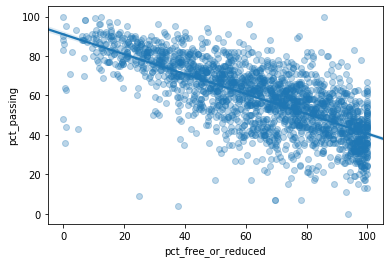

In [80]:
sns.regplot(data=merged,
            x='pct_free_or_reduced',
            y='pct_passing',
            scatter_kws={'alpha':0.3})

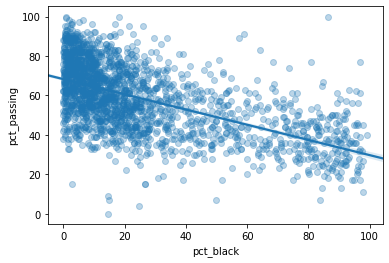

In [81]:
sns.regplot(data=merged,
            x='pct_black',
            y='pct_passing',
            scatter_kws={'alpha':0.3})

This is people start yelling "Look at that line! It goes down! Negative correlation, case closed!" But no, we're better than this. We know about linear regression! We'll use it to **quantify the relationship.**

## Linear regression

Now let's be a little more exact, and run a linear regression that takes into account both percent black and percent free or reduced.

In [82]:
# We'll remove any rows missing data
print("Before removing missing data:", merged.shape)
merged = merged.dropna()
print("After removing missing data:", merged.shape)

Before removing missing data: (2189, 7)
After removing missing data: (2070, 7)


In [85]:
import statsmodels.formula.api as smf

model = smf.ols('pct_passing ~ pct_black + pct_free_or_reduced', data=merged)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            pct_passing   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     1398.
Date:                Tue, 25 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:10:20   Log-Likelihood:                -7963.4
No. Observations:                2070   AIC:                         1.593e+04
Df Residuals:                    2067   BIC:                         1.595e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              89.3659      0.707    126.460      0.000      87.980      90.752
pct_black              -0.2041      0.011    -18.669      0.000      -0.226      -0.183
pct_free_or_reduced    -0.3984      0.012    -34.271      0.000      -0.421      -0.376
==============================================================================
Omnibus:                      178.385   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.988
Skew:                          -0.423   Prob(JB):                    1.52e-122
Kurtosis:                       5.406   Cond. No.                         213.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Understanding the regression

Most of the time when performing a regression, we're looking for a "when X goes up this much, Y goes up this much" kind of sentence. In this case, we see our **pct_free_or_reduced** coefficient is about -0.4. This can be explained by a sentence like:

> Controlling for race, every 10 percentage point increase in free or reduced lunch translates to a 4 point drop in passing rate

We could do the same thing with the **pct_black** coefficient, too.

> Controlling for free or reduced lunch, every 10 percentage point increase in black students translates to a 2 point drop in passing rate

There's only one issue with performing linear regressions as a journalist, though: **these numbers don't tell us much that's actually useful.** While it's certainly an extra number you could try to throw into your story, it doesn't really mean much more than "income is more important than race."

Before we find out the flaws in our data, let's first see how to put this regression to use.

## Overperformers and underperformers

One of the most useful things you can do with a regression is **make predictions**. We can actually use our regression to say hey, now that you've looked at all of these schools and figured out the relationship between these variables, **what should each school have scored?**

### Making predictions

We can use `result.predict()` to get the predicted passing rate for each school.

In [86]:
result.predict()

array([32.72266299, 61.72216826, 57.36516932, ..., 77.7076644 ,
       42.22023935, 75.18874729])

Now, let's **save that value into a new column**, we can call it `predicted_passing`.

In [87]:
merged['predicted_passing'] = result.predict()
merged.head()

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black,predicted_passing
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,95.911950,90.322581,32.722663
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,54.668930,28.737542,61.722168
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,60.698690,38.315789,57.365169
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,95.765472,84.923077,33.883060
6,01,ALACHUA,0091,LITTLEWOOD ELEMENTARY SCHOOL,56.0,59.394904,30.733229,59.432166


We can use this predicted passing rate to find **the difference between the actual passing rate and the predicted passing rate**. That way we can see which schools did better or worse than they were predicted to do.

> If we're being stats-y, this is called **the residual**.

In [88]:
merged['residual'] = merged['pct_passing'] - merged['predicted_passing']
merged.head()

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black,predicted_passing,residual
0,01,ALACHUA,0021,CHARLES W. DUVAL ELEM SCHOOL,36.0,95.911950,90.322581,32.722663,3.277337
1,01,ALACHUA,0031,J. J. FINLEY ELEMENTARY SCHOOL,74.0,54.668930,28.737542,61.722168,12.277832
2,01,ALACHUA,0041,STEPHEN FOSTER ELEMENTARY SCHOOL,71.0,60.698690,38.315789,57.365169,13.634831
4,01,ALACHUA,0071,LAKE FOREST ELEMENTARY SCHOOL,19.0,95.765472,84.923077,33.883060,-14.883060
6,01,ALACHUA,0091,LITTLEWOOD ELEMENTARY SCHOOL,56.0,59.394904,30.733229,59.432166,-3.432166


### Using predictions

Now we could find, for example, the top 5 schools that did better or worse than expected.

In [91]:
# Negative residual, did worse than expected 
merged.sort_values(by='residual').head(5)

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black,predicted_passing,residual
1410,48,ORANGE,0055,PRINCETON HOUSE CHARTER,9.0,25.000000,14.743590,76.397521,-67.397521
1073,29,HILLSBOROUGH,6609,PEPIN ACADEMIES,4.0,37.653240,24.747475,69.315062,-65.315062
2180,68,FSDB,0011,DEAF ELEMENTARY SCHOOL (FSDB),7.0,69.491525,14.782609,58.665531,-51.665531
1717,50,PALM BEACH,4037,LEARNING PATH ACADEMY,0.0,93.650794,14.569536,49.084725,-49.084725
1948,53,POLK,9203,B.E.S.T.,7.0,69.767442,50.000000,51.367702,-44.367702


In [92]:
# Positive residual, did better than predicted
merged.sort_values(by='residual', ascending=False).head(5)

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black,predicted_passing,residual
165,06,BROWARD,0701,PARKWAY MIDDLE SCHOOL,100.0,85.758706,86.286788,37.591106,62.408894
304,06,BROWARD,5372,PATHWAYS ACADEMY K-8 CENTER,83.0,95.652174,64.206642,38.156444,44.843556
661,13,MIAMI DADE,5131,N DADE CENTER FOR MODERN LANGUAGE,89.0,76.767677,57.323232,47.084347,41.915653
566,13,MIAMI DADE,3101,FRANK CRAWFORD MARTIN K-8 CENTER,91.0,54.096916,59.079284,55.757254,35.242746
2187,74,FAMU LAB SCH,0351,FAMU DEVELOP RESEARCH,77.0,68.710359,96.881497,42.220239,34.779761


In [99]:
featured_names = [
    'LAKEWOOD ELEMENTARY SCHOOL',
    'CAMPBELL PARK ELEMENTARY SCHOOL',
    'MAXIMO ELEMENTARY SCHOOL',
    'MELROSE ELEMENTARY SCHOOL',
    'FAIRMOUNT PARK ELEMENTARY SCHOOL'
]

is_pinellas = merged['District Name'] == 'PINELLAS'
is_featured = merged['School Name'].isin(featured_names)

featured = merged[is_featured & is_pinellas]
featured

,District Number,District Name,School Number,School Name,pct_passing,pct_free_or_reduced,pct_black,predicted_passing,residual
1783,52,PINELLAS,0481,CAMPBELL PARK ELEMENTARY SCHOOL,22.0,75.850891,79.928952,42.835711,-20.835711
1789,52,PINELLAS,1211,FAIRMOUNT PARK ELEMENTARY SCHOOL,7.0,78.101072,83.821263,41.144884,-34.144884
1803,52,PINELLAS,2021,LAKEWOOD ELEMENTARY SCHOOL,29.0,71.272727,76.639344,45.330921,-16.330921
1806,52,PINELLAS,2281,MAXIMO ELEMENTARY SCHOOL,21.0,67.128713,82.932166,45.697393,-24.697393
1808,52,PINELLAS,2371,MELROSE ELEMENTARY SCHOOL,18.0,82.706767,86.238532,38.816752,-20.816752


From looking at our results, all of the featured Pinellas County schools are performing well below expectations. **We have a few problems, though!**

#### Exceptional student education

If you read through [the critique](https://rogueedu.blogspot.com/2015/08/fcat-reading-scores-only-two-of-five.html), it involves a feature that we don't have - exceptional students minus gifted. Exceptional students include students with all manner of disabilities or special circumstances - deaf students, emotional disabilities, autism spectrum, developmentally disabled, and many more categories.

If a school has an especially high or low number of these students, it's sure to affect their passing rates. Why don't we have it in our analysis? **I couldn't find the data on a school level, only on the county level.** According to the author, just by adding that one column suddenly three of our residuals swing to positive, and our huge negatives come much closer to the center:

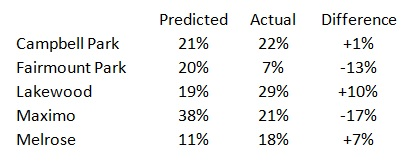

How were we supposed to know that ESE students have such an impact? This is why you always run your analysis by the experts! They'll be able to suggest other columns you might want to add to your regression, and help you understand whether their impact is meaningful or not.

For example, whether ESE students are required to take tests or not would have a large impact on whether that additional information is meaningful. 

### Free lunch gotchas (a big one!)

Speaking of experts: free lunch seems pretty straightforward, right? Even though it's a popular benchmark for analysis, **it turns out that things aren't so simple.**

It turns out that many schools and school systems across the US have simplified the free lunch program: instead of students needing to meeting a certain income requirements, lunch for *all students is federally funded*. While these are typically high-poverty areas, you can no longer use the percent free lunch as a meaningful proxy for poverty if *all of the students can receive it, regardless of income.*

Additionally, this new system was adopted at different rates and in different ways across districts and states, which makes measurements even less useful!

**So where does that leave us?** If we can't use free lunch, we're now stuck with just using race as our only regression feature. Seems a little simplistic!

## A completely different approach

Instead of trying to see what schools performed well and what schools performed poorly, let's step back and examine our underlying assumptions. Powered by statistics, we've come to the conclusion that **school systems with more minority students and more poverty have lower passing rates.** 

Our research was meant to find the relationship between those variables and uncover which schools were doing better or worse than one would expect them to. Maybe we could use this as a jumping off point to examine these schools. **For the high performers, what were they doing differently than the low performers?** For the lower performers, what external factors might be pulling them down, or what lessons might they learn from the high performers in a similar group?

Linear regression is a great tool to understand the relationship between variables, but **linear regression doesn't tell you what to do once you've found the problem.** When we have "everything else considered equal," we're making an implicit assumption that _those things can't change._

The Tampa Bay Times research was something different: yes, these schools are predominantly poor and black, but **they are poor and black because of public policies.**

# What problems might our analysis have?

We brought in two things we thought would do a good job covering socioeconomics and demographic patterns. What else might we be missing?

* **Tip:** Pay attention to the names of the schools

Is there a between using the raw number for the residual as opposed to standard deviation? (See Texas schools cheating scandal)

* https://www.npr.org/sections/ed/2015/01/30/379330001/true-or-false-free-and-reduced-price-lunch-poor
* https://nces.ed.gov/blogs/nces/post/free-or-reduced-price-lunch-a-proxy-for-poverty
* https://www.ers.usda.gov/topics/food-nutrition-assistance/child-nutrition-programs/national-school-lunch-program/